### 3.2 线性回归的从零开始实现

In [7]:
%matplotlib inline
import random
import torch
import utils

#### 3.2.1 生成数据集

我们使用线性模型参数 $\mathbf{w} = [2, -3.4]^\top$ , $b = 4.2$ 和噪声项 $\epsilon$

$$
\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.
$$

标准差为0.01

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.9420, 0.9915]) 
label: tensor([2.7164])


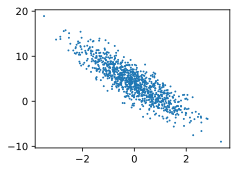

In [8]:
utils.set_figsize()
utils.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

#### 3.2.2 读取数据集

打乱数据集中的样本并以小批量方式获取数据

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [16]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.5553, -2.1357],
        [-0.2423, -1.4864],
        [ 0.1771,  0.2672],
        [ 0.7273,  2.8224],
        [-0.7163,  1.6975],
        [-0.2717,  2.1431],
        [-0.5005, -0.6292],
        [ 0.5654,  0.1722],
        [ 2.0271,  0.7024],
        [-1.2262, -0.2638]]) 
 tensor([[10.3480],
        [ 8.7817],
        [ 3.6326],
        [-3.9193],
        [-2.9998],
        [-3.6138],
        [ 5.3523],
        [ 4.7357],
        [ 5.8726],
        [ 2.6506]])


#### 3.2.3 初始化模型参数

从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0

In [17]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

#### 3.2.4 定义模型

In [18]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

#### 3.2.5 定义损失函数

In [19]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#### 3.2.6 定义优化算法

小批量随机梯度下降

In [20]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

#### 3.2.7 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。 理解这段代码至关重要，因为从事深度学习后， 相同的训练过程几乎一遍又一遍地出现。 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。

概括一下，我们将执行以下循环：

- 初始化参数
- 重复以下训练，直到完成
  - 计算梯度 $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
  - 更新参数 $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。 这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。 设置超参数很棘手，需要通过反复试验进行调整。 我们现在忽略这些细节，以后会在 11节中详细介绍。

In [21]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.034788
epoch 2, loss 0.000129
epoch 3, loss 0.000052


In [22]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001, -0.0008], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0014], grad_fn=<RsubBackward1>)


### 3.3 线性回归的简洁实现

In [4]:
# 生成数据集

import numpy as np
import torch
from torch.utils import data
import utils

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
# 读取数据集

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [6]:
# 取数据

next(iter(data_iter))

[tensor([[-0.0719,  0.7608],
         [-1.1341,  2.2916],
         [-2.0957,  2.3810],
         [ 0.6015, -0.4906],
         [ 0.0673, -0.9638],
         [-0.8743, -1.4724],
         [ 0.4440, -1.7671],
         [ 0.1213,  1.5611],
         [-0.2621, -1.4135],
         [-0.4134,  1.8281]]),
 tensor([[ 1.4872],
         [-5.8366],
         [-8.0950],
         [ 7.0759],
         [ 7.6262],
         [ 7.4638],
         [11.0976],
         [-0.8763],
         [ 8.4803],
         [-2.8296]])]

In [7]:

# 定义模型

# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [8]:
# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [9]:
# 定义损失函数
loss = nn.MSELoss()

In [10]:
# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [11]:
# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000189
epoch 2, loss 0.000106
epoch 3, loss 0.000108


In [12]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0001,  0.0016])
b的估计误差： tensor([-0.0006])


### 3.4 softmax回归

分类问题

$\{\text{狗}, \text{猫}, \text{鸡}\}$ 类似的分类问题


